# 匯入一些套件還有匯入文檔

In [37]:
%pylab inline
import time
import re
import matplotlib.pyplot as plt
import pandas as pd
import string
import codecs
import os
import jieba
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn import naive_bayes as bayes
from sklearn.model_selection import train_test_split
#簡轉繁
from hanziconv import HanziConv

#ham與spam的每封郵件list
ham_text = []
spam_text = []
#ham與spam的數據集
ham_data = []
spam_data = []
#取得目前工作目錄
SaveDirectory = os.getcwd() 
#獲得文檔列表
listham = os.listdir(SaveDirectory+'\\data\\normal')
listspam = os.listdir(SaveDirectory+'\\data\\spam')
#數據集數量

print('spam total：',len(listspam))
print('ham total：',len(listham))


Populating the interactive namespace from numpy and matplotlib
spam total： 7775
ham total： 7063


C:\Users\zxc98\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 先匯入HAM文檔並給予label = 0

In [38]:
for fileName in listham:
        with open('data/normal/'+fileName, 'r',encoding='gbk') as f:
            #文本每一列儲存
            text=[]
            # 過濾非中文字符，正規化
            for line in f.readlines():
                pattern = re.compile('[^\u4e00-\u9fa5]') #正規化(去除非中文字符)
                line = pattern.sub("", line) #將其他字符取代為""
                content = line.strip().split() #去除一些空白.換行
                text = text+content #儲存這個文本的內容
            text = " ".join(text) #將文本內容list加入全部文本的list
            ham_text.append(HanziConv.toTraditional(text)) #簡轉繁
ham_data = pd.DataFrame(ham_text,columns=['text']) #將list改成dataframe
ham_data['label']='0' #將資料類別加上 0:ham 1:spam
ham_data.head()


,text,label
0,這事兒還有續集 因為我姐她們買房子後來裝修的時候沒錢她婆婆他們就贊助瞭萬塊 這下一吵她婆婆就...,0
1,越發覺得這個姐夫不錯瞭 那萬還是趕緊還瞭吧 標題姐姐快要生孩子瞭很感慨 發信站水木社區站內 ...,0
2,或許某些農村吧 在一個當性彆勞動力富裕程度的地方還是可以理解的 標題姐姐快要生孩子瞭很感慨 ...,0
3,最近經常看到你說一些很武斷的話 所謂保胎確實是要躺在床上不能動的尤其是先兆流産有齣血的時候 ...,0
4,他們分手是說性格不閤 沒多久然後我們交往 還算比較愉快 當初因為他經常和聯係我曾跟他吵過多次...,0


# 先匯入SPAM文檔並給予label = 1

In [39]:
for fileName in listspam:
        with open('data/spam/'+fileName, 'r',encoding='gbk') as f:
            text=[]
            # 过滤掉非中文字符
            for line in f.readlines():
                pattern = re.compile('[^\u4e00-\u9fa5]')
                line = pattern.sub("", line)
                content = line.strip().split()
                text = text+content
            text = " ".join(text)
            spam_text.append(HanziConv.toTraditional(text))
spam_data = pd.DataFrame(spam_text,columns=['text'])
spam_data['label']='1'
spam_data.head()

,text,label
0,會員注冊邀請書 全國最低價域名空間大放送 國際頂級域名注冊驚暴價元年元年連續注冊年以上 國傢...,1
1,你好 以茶會友以茶聯誼喝茶就喝安溪鐵觀音 本廠是專業生産批發各等級鐵觀音茶葉的購買聯係 在綫...,1
2,尊敬的先生小姐 您好 首先感謝您抽時間查看以下信息 我公司一直緻力於研發生産銷售施工環氧樹脂...,1
3,先生 你好 批發麻醉藥催情藥墮胎藥避孕藥飲料型噴霧型香煙型揮發型等各類國際國內製藥企業推齣的...,1
4,貴公司負責人經理財務您好 我是深圳市創偉實業有限公司的我司實力雄厚有著良 好的社會關係也有部...,1


# 把匯入的 SPAM與HAM結合並打亂

In [40]:
all_data = pd.concat([spam_data,ham_data],axis=0, ignore_index=True)  #將ham lsit與spam list串起來
all_data = all_data.sample(frac=1).reset_index(drop=True) #sample frac = 1 是把數據都打亂 resr_index是把index也重設
print('data shape：',all_data.shape)
print('spams in rows：',all_data.loc[all_data['label']=="1"].shape[0])
print('hams in rows：',all_data.loc[all_data['label']=="0"].shape[0])
all_data.head(6)

data shape： (14838, 2)
spams in rows： 7775
hams in rows： 7063


,text,label
0,一般的房子除瞭房租和取暖費其他的費用要多少錢包括水電氣閉路寬帶一個月大概花多少我和另人閤租的...,0
1,貴公司負責人經理財務您好 我是深圳市粵佳實業有限公司的廣州東莞等市有分公司 我司實力雄厚有著...,1
2,這個男人也算不上什麼成功吧我看他娶我朋友倒是他生活的成功開始纔對早年名牌大學畢業但走瞭十年的...,0
3,寒尤其是第二個 手洗更洗不乾淨的怎麼辦 自從確認懷孕瞭以後我的苦日子就開始瞭因為老婆撂瞭挑子...,0
4,尊敬的新老客戶 您們好 深圳市中泰實業有限公司國內設有多傢分公司實力雄厚有著良 好的社會關係...,1
5,上海輝然華貿易有限公司是一傢集産品研究開發生産代理銷售電子商務於一體的多元化貿易企業其所屬産...,1


# 接著載入停詞表及斷詞

In [41]:
#載入 停用詞 (stopwords) 自動過濾掉某些字或詞
stopwords = codecs.open(os.path.join(SaveDirectory+'\data', 'stopwords_tr.txt'), 'r', 'utf-8').read().split('\r\n')
#下面斷詞
processed_texts = []
for text in all_data["text"]:
    words = []
    seg_list = jieba.cut(text) #利用Jieba斷詞
    for seg in seg_list: 
        # isalpha()檢測詞是否由字符組成，且不在停用詞的list中
        if (seg.isalpha()) & (seg not in stopwords):
            words.append(seg)
    sentence = " ".join(words)
    processed_texts.append(sentence)
all_data["text"] = processed_texts #利用過濾且斷好的詞取代文本


# 接著將資料切成訓練及與測試集

In [42]:
#traindate & testdata
train_set, test_set, trainlabel, testlabel = train_test_split(all_data["text"], all_data["label"], test_size = 0.15)

In [43]:
print("train:"+str(len(train_set)))
print("test:"+str(len(test_set)))
trainlabel[trainlabel=='1'].shape

train:12612
test:2226


(6640,)

In [44]:
trainlabel_orig = trainlabel.copy()
# 取消一些標記的數據
unlabeled_size = 2597
#loc可以選擇數據(把上面數量的POSTIVE DATA隱藏為UNLABELED DATA)
trainlabel.loc[
    np.random.choice(
        trainlabel[trainlabel == '1'].index, 
        replace = False, 
        size = unlabeled_size
    )
] = '0'
trainlabel[trainlabel=='1'].shape

(4043,)

In [45]:
positive_train = trainlabel[trainlabel=='1'].index
positive_data = train_set[positive_train]
positive_spam = pd.DataFrame(
    {
     'text':positive_data, 
     'label':trainlabel[positive_train],
     'truth':trainlabel_orig[positive_train]
    })
positive_spam.shape


(4043, 3)

In [46]:
import re
def generate_key_list(all_data, size_table=200,ignore=2):
    dict_spam_raw = dict()
    dict_genuine_raw = dict()
    dict_IDF = dict()

    # 去除字母外的所有內容.
    for i in range(all_data.shape[0]):
        finds = all_data.iloc[i].text.split(" ")
        if all_data.iloc[i].label == '1':
            for find in finds:
                if len(find)<ignore: continue
                try:
                    dict_spam_raw[find] = dict_spam_raw[find] + 1
                except:	
                    dict_spam_raw[find] = dict_spam_raw.get(find,1) #若是新的文字因為後面get找不到這個索引會返回逗點後面的值
                    dict_genuine_raw[find] = dict_genuine_raw.get(find,0)
        else:
            for find in finds:
                if len(find)<ignore: continue
                try:
                    dict_genuine_raw[find] = dict_genuine_raw[find] + 1
                except:	
                    dict_genuine_raw[find] = dict_genuine_raw.get(find,1)
                    dict_spam_raw[find] = dict_spam_raw.get(find,0)

        word_set = set()
        for find in finds:
            if not(find in word_set):
                if len(find)<ignore: continue
                try:
                    dict_IDF[find] = dict_IDF[find] + 1
                except:	
                    dict_IDF[find] = dict_IDF.get(find,1)
            word_set.add(find)
    word_df = pd.DataFrame(list(zip(dict_genuine_raw.keys(),dict_genuine_raw.values(),dict_spam_raw.values(),dict_IDF.values())))
    word_df.columns = ['keyword','genuine','spam','IDF']
    word_df['genuine'] = word_df['genuine'].astype('float')/all_data[all_data['label']=='0'].shape[0]
    word_df['spam'] = word_df['spam'].astype('float')/all_data[all_data['label']=='1'].shape[0]
    word_df['IDF'] = np.log10(word_df.shape[0]/word_df['IDF'].astype('float'))
    word_df['genuine_IDF'] = word_df['genuine']*word_df['IDF']
    word_df['spam_IDF'] = word_df['spam']*word_df['IDF']
    word_df['diff']=word_df['spam_IDF']-word_df['genuine_IDF']
    selected_spam_key = word_df.sort_values('diff',ascending=False)  
    keyword_dict = dict()
    i = 0
    for word in selected_spam_key.head(size_table).keyword:
        keyword_dict.update({word.strip():i})
        i+=1
    return keyword_dict   
# build a tabu list based on the training data
size_table = 200               # 多少特徵維度去分類SPAM
word_len_ignored = 2            # 忽略那些比這個還要小的字詞
keyword_dict=generate_key_list(positive_spam, size_table, word_len_ignored)

In [47]:
#排序越前面的代表出現在SPAM的機率越大
for key,value in keyword_dict.items():
    print('{key}:{value}'.format(key = key, value = value))

尊敬:0
公司:1
領導:2
能為:3
貴司:4
代理:5
對開:6
增值:7
稅發票:8
電腦:9
收費:10
普通:11
國稅:12
建築安裝:13
建築:14
廣告:15
運輸:16
服務行業:17
汽車:18
維修:19
各類:20
專用:21
發票:22
數額:23
商談歡:24
迎來:25
電洽:26
謝謝:27
本郵件:28
無關:29
隨手:30
刪除:31
造成:32
不便:33
歉意:34
先生:35
電話:36
順祝:37
商祺:38
您好:39
廣東:40
嘉禾:41
貿易:42
有限公司:43
多年:44
發展:45
不斷:46
壯大現:47
全國:48
各省市:49
上百:50
有著:51
密切:52
業務聯:53
優惠代:54
開海:55
關代徵:56
稅專用:57
繳款:58
地稅代:59
開範圍:60
商品:61
銷售:62
服務:63
餐飲:64
定額:65
廣東省:66
銷售統:67
一發票:68
可根據:69
所開:70
數量:71
額度:72
大小:73
衡量:74
優惠:75
點數本:76
鄭重:77
承諾:78
所用:79
票據:80
單位:81
稅務:82
局所:83
申領:84
可上:85
網查:86
詢電話:87
查詢:88
局驗證:89
業務範:90
圍代開:91
詳情:92
李小姐:93
手機:94
傳真:95
地址:96
州市:97
白雲區:98
負責人:99
經理:100
財務:101
鵬輝:102
實業:103
廣州:104
東莞:105
分公司:106
我司:107
實力:108
雄厚:109
良好:110
社會關:111
進項:112
多現:113
完成:114
每月:115
售額度:116
一部分:117
稅電腦:118
海關:119
左右:120
普通商品:121
銷售稅:122
服務廣告:123
交通:124
工程:125
優惠代開:126
作點:127
數較:128
商討:129
點數:130
成立:131
一直:132
堅持:133
以誠信:134
中心:135
核心思想:136
牢固:137
樹立:138
真正:139
做到:140
閤作:141
一次:142
永久:143
朋友:144
用絕:145
真票:146
希望:147
能夠:148
機會:149
如貴司:150
疑慮:151
擔

In [48]:
unlabeled_train = trainlabel[trainlabel=='0'].index
unlabeled_data = train_set[unlabeled_train]
unlabeled_df = pd.DataFrame(
    {
        'text':unlabeled_data, 
        'label':trainlabel[unlabeled_train],
        'truth':trainlabel_orig[unlabeled_train]
    })
unlabeled_df.head()

,label,text,truth
7091,0,祝 瞭 年前 歲 生日 傢 人 第一次 準備 瞭 生日蛋糕 心急如焚 碩鼠 如梭 蒼蠅 狂舞...,0
5178,0,年 最新 暢銷 圖書 特書 幾百個 品種 一律 特價書 銷售 歡迎 全國 各書 商來 電來 ...,1
5629,0,標題 傢 判斷 一下 那女 迴 事 發信 站 社區 站 脾氣 真好 不準 男朋友 女人 單獨...,0
165,0,尊敬 公司 領負 責人 經理 財務 好 佰成 實業 有限公司 我司 實力 雄厚 著艮好 社 ...,1
2170,0,公司 負責人 你好 公司 維 拉德 實業 有限公司 公司 現有 大量 餘額 發票 優惠代開 ...,1


In [49]:
all_data = pd.concat([positive_spam,unlabeled_df],axis=0, ignore_index=False)  #將ham lsit與spam list串起來
all_data = all_data.sample(frac=1) #sample frac = 1 是把數據都打亂
all_data.head(10)


,label,text,truth
3695,0,總 想 認識 好 推銷 齣 希望 得到 幸福 可惜 男孩子 總 喜歡 知道 是不是 眼光 不...,0
13765,0,最最 眩手 機上 看看 雜誌 手機 幫 發無聊 時光 隻 手機 隨時 隨地 翻閱 想 雜誌,1
394,0,平心 願意 不願意 嶽 父 嶽 母加 小舅子 一直 常住 一起 理解 心理 傢 子 隻 血緣...,0
3900,0,公司 勞動 閤 裏 違約 條款 標題終 理解 公司 清華 學生 瞭 發信 站 社區 站 學期...,0
11289,0,北京 大地 和諧 環境 工程 技術 有限公司 傢 知名 國際 公司 代理 公司 主要 從事水...,0
6699,0,公司 負責人 經理 財務 您好 華隆源 實業 有限公司 廣州 東莞 市 分公司 我司 實力 ...,1
4898,0,公司 負責人 你好 公司 紅樹林 實業 有限公司 具有 良 好 進口 來源 剩餘 發票 廣泛...,1
12008,1,公司 負責人 經理 財務 您好 創達 實業 有限公司 我司 實力 雄厚 著良 好 社會關 係...,1
2811,0,尊敬 先生 小姐 您好 感謝 抽 時間 查看 以下 信息 公司 一直 緻 力 研 發 生 産...,1
12559,0,標題 追 追 多久 還沒 追上 放手 發信 站 社區 站 欲 擒 一個 女孩 錶 現 齣 親...,0


In [50]:
# all_data.loc[positive_train[:]]
all_data['truth'] = trainlabel_orig
all_data['label'][all_data['label']=="1"].shape

(4043,)

In [51]:
 all_data['label'][all_data['label'] == '1'].shape

(4043,)

In [354]:
unlabeled_size = 3200
sp_index=[]
sp_index = all_data['label'].loc[
    np.random.choice(
        all_data['label'][all_data['label'] == '1'].index, 
        replace = False, 
        size = unlabeled_size
    )
].index
sp_index
# all_data.loc[positive_train[:]]

Int64Index([10137, 10619,  4233,  1610,   260,  1961,  6570,  9738,  5929,
             8924,
            ...
            12991, 11812, 13037,  7191,  4104, 10356,  3969,  6016,   840,
             9994],
           dtype='int64', length=3200)

In [355]:
all_data['label'].loc[sp_index[:]] = 0 #SP
all_data['label'].loc[sp_index[:]].shape

(3200,)

# -------------------------------SP  上面

In [356]:
def convert_Content(text, keyword_dict):
    #判斷是否有此特徵
    m = len(keyword_dict) #維度數量
    res = np.int_(np.zeros(m)) #建置一個幾維度的向量
    finds = text.split(" ") #將文本內容切割(類似中文斷詞)
    for find in finds:
        try:
            #若比對完有此特徵則特徵改為1
            i = keyword_dict[find] 
            res[i]=1
        except:
            continue
    return res
def raw2feature(all_data,keyword_dict):
    n_all_data = all_data.shape[0]
    m = len(keyword_dict)
    X_all_data = np.zeros((n_all_data,m));
    Y_all_data = np.int_(all_data.label=='1')
    for i in range(n_all_data):
        X_all_data[i,:] = convert_Content(all_data.iloc[i].text, keyword_dict)
    return [X_all_data,Y_all_data]
     
all_data_matrix=raw2feature(all_data,keyword_dict)

In [357]:
# positive_train  正樣本的index
# unlabeled_train 未標記樣本的index
# all_train 混合完的index
all_data_matrix[1][all_data_matrix[1]==1].shape

(843,)

# 使用一般隨機森林計算他們的機率

In [358]:
# 使用一般的隨機森林算法
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators = 1000,  # 使用1000顆決策樹
    n_jobs = -1           # 使用全部的CPU合運算
)
rf.fit(all_data_matrix[0], all_data_matrix[1])

# 儲存次方法給定的分數
results = pd.DataFrame({
    'truth'      : all_data['truth'],   # 真實標籤
    'label'      : all_data['label'],        # 預測標籤
    'output_std' : rf.predict_proba(all_data_matrix[0])[:,0],   # 隨機森林分數(求屬於標籤1的概率)
}, columns = ['truth', 'label', 'output_std'])
# print(results)

In [359]:
results.loc[sp_index[:]].head()


,truth,label,output_std
10137,1,0,0.796776
10619,1,0,0.941307
4233,1,0,1.000000
1610,1,0,0.999616
260,1,0,0.972691


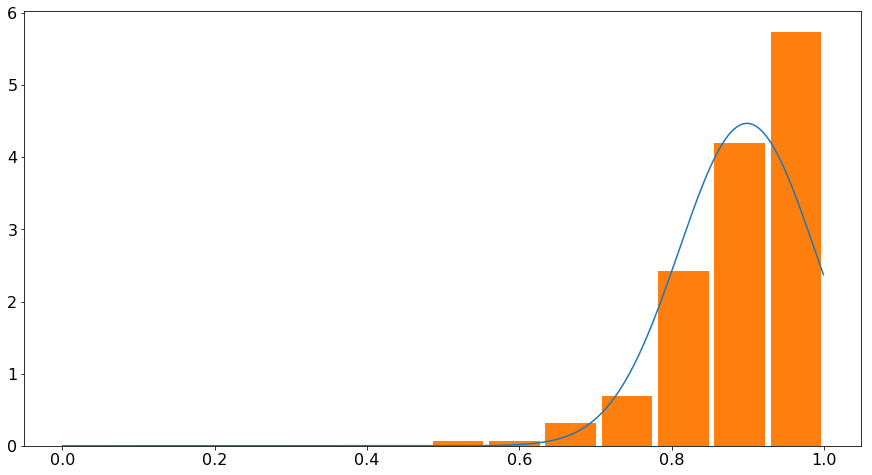

(5,)


In [360]:
from scipy import stats
sp_data = results['output_std'].loc[sp_index[:]]
sp_counts = len(results['output_std'].loc[sp_index[:]])
sp_mean = results['output_std'].loc[sp_index[:]].mean()
sp_std = results['output_std'].loc[sp_index[:]].std()
# 绘制概率密度分布图
x = np.arange(0, 1, 0.001)
# PDF是概率密度函数
y = stats.norm.pdf(x, loc=sp_mean, scale=sp_std)
plt.plot(x, y)
plt.hist(sp_data, bins=10, rwidth=0.9, normed=True)
plt.show()
print(results['output_std'].loc[sp_index[:]][results['output_std']<0.5].shape)

In [361]:
from scipy import stats
ci = 0.68
for i in range(11):
    conf_intveral = stats.norm.interval(ci, loc=sp_mean, scale=sp_std) #數字為信賴區間
    ci += 0.02
    print(conf_intveral)
    t=[]
    t = sp_data[sp_data<conf_intveral[1]]
    t = t[t>conf_intveral[0]]
    RN = results
    RN = RN[(~RN.index.isin(sp_index))] #去除U中的SP
    RN_index = RN['output_std'][RN['output_std']>=max(t)].index
    print(1-np.int_(RN['truth'].loc[RN_index[:]]).mean())
    
    
# 函数曲线下68.268949%的面积在平均数左右的一个标准差范围内

# 函数曲线下95.449974%的面积在平均数左右两个标准差的范围内

# 函数曲线下99.730020%的面积在平均数左右三个标准差的范围内

# 函数曲线下99.993666%的面积在平均数左右四个标准差的范围内

(0.8099291684642691, 0.987367047004309)
0.8754440497335702
(0.8061843920833711, 0.9911118233852071)
0.87545609340793
(0.8022691784621538, 0.9950270370064243)
0.8798727128082737
(0.79815895896417, 0.9991372565044081)
0.9051697766901193
(0.7938235760890412, 1.003472639379537)
0.9088308902395423
(0.7892254005168855, 1.0080708149516926)
0.9088308902395423
(0.7843165735038253, 1.0129796419647528)
0.9088308902395423
(0.7790348325838052, 1.0182613828847729)
0.9088308902395423
(0.7732969384853752, 1.023999276983203)
0.9088308902395423
(0.7669878164189131, 1.030308399049665)
0.9088308902395423
(0.7599415154827851, 1.037354699985793)
0.9088308902395423


In [362]:
max(sp_data)

1.0

In [363]:
t = sp_data[sp_data<conf_intveral[1]]
t = t[t>conf_intveral[0]]
max(t)

1.0

In [364]:
RN = results
RN = RN[(~RN.index.isin(positive_train))] #去除ALL中的SP,P剩下U
RN_index = RN['output_std'][RN['output_std']>=max(t)].index
1-np.int_(RN['truth'].loc[RN_index[:]]).mean()

0.9088308902395423

In [365]:
RN_index.shape

(2797,)

# 下面是將test資料轉換為矩陣

In [366]:
test_data = pd.DataFrame({
    'text'      : test_set,   # 真實標籤
    'label'      : testlabel,        # 預測標籤
}, columns = ['text', 'label'])

In [367]:
#將測試及轉為稀疏矩陣，是舊的TFIDF
test_data_matrix = raw2feature(test_data,keyword_dict)

In [368]:
def test_func(test,testlabel,model):
    Y_hat = model.predict(test)
    n=np.size(testlabel)
    print ('Testing Accuarcy: {:.2f}％ ({})'.format(sum(np.int_(Y_hat==testlabel))*100./n,model.__module__))
# Test Model using testing data

test_func(test_data_matrix[0],test_data_matrix[1],rf)

Testing Accuarcy: 49.55％ (sklearn.ensemble.forest)


# 下面是提取RN後用P和RN重新訓練

In [369]:
all_data.loc[positive_train]
all_data.loc[RN_index]
all_data['label'].loc[sp_index] = '1'
new_all_data=[]
new_all_data = pd.concat([all_data.loc[positive_train],all_data.loc[RN_index]])

In [370]:
new_keyword_dict=generate_key_list(all_data, size_table, word_len_ignored) #TFIDF

In [371]:
new_all_data_matrix = raw2feature(new_all_data,keyword_dict)
from sklearn.ensemble import RandomForestClassifier

rfpu = RandomForestClassifier(
    n_estimators = 1000,  # 使用1000顆決策樹
    n_jobs = -1           # 使用全部的CPU合運算
)
rfpu.fit(new_all_data_matrix[0], new_all_data_matrix[1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [372]:
test_func(test_data_matrix[0],test_data_matrix[1],rfpu)

Testing Accuarcy: 72.91％ (sklearn.ensemble.forest)


In [373]:
all_data['label'][all_data['label']=="1"].shape

(4043,)

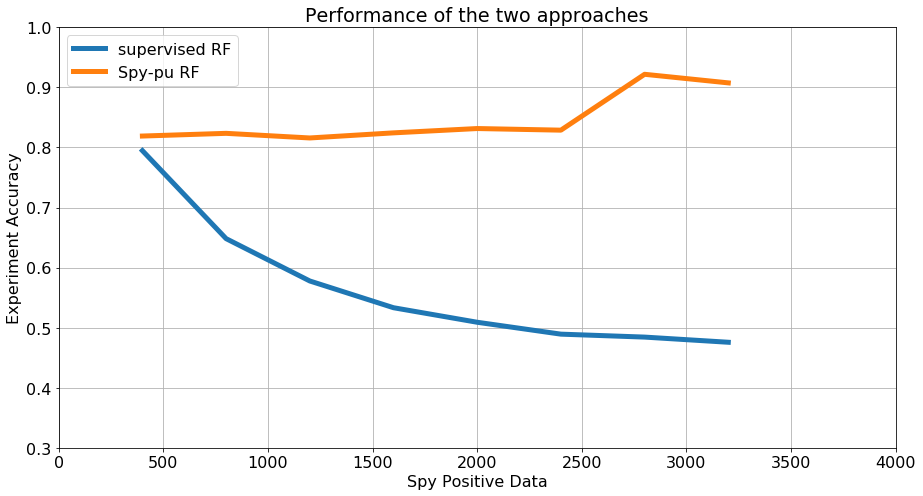

In [374]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 15, 8
x = [400, 800, 1200, 1600,2000,2400,2800,3200]
y_std = [0.7947, 0.6482, 0.5777, 0.5332,0.5090,0.4892,0.4843,0.4757]
y_stdpu = [0.8190, 0.8235, 0.8158, 0.8243,0.8315,0.8288,0.9218,0.9075]
plt.xlim(0, 4000)
plt.ylim(0.3, 1)
plt.plot(x, y_std, marker='', mec='b', mfc='w' ,lw = 5)
plt.plot(x, y_stdpu, marker='', mec='b', mfc='w' ,lw = 5)
plt.legend([
    'supervised RF', 
    'Spy-pu RF'
])  # 让图例生效
# plt.xticks(x, names, rotation=45)
plt.margins(0)
plt.subplots_adjust(bottom=0.15)
plt.xlabel(u"Spy Positive Data") #X轴标签
plt.ylabel("Experiment Accuracy") #Y轴标签
plt.title("Performance of the two approaches") #标题
plt.savefig("classifier ")
plt.grid()
plt.show()